In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from Farm_Evaluator_Vec import *

In [ ]:
'''preprocessing to compute AEP'''

# Turbine Specifications.
# -**-SHOULD NOT BE MODIFIED-**-
turb_specs    =  {   
                     'Name': 'Anon Name',
                     'Vendor': 'Anon Vendor',
                     'Type': 'Anon Type',
                     'Dia (m)': 100,
                     'Rotor Area (m2)': 7853,
                     'Hub Height (m)': 100,
                     'Cut-in Wind Speed (m/s)': 3.5,
                     'Cut-out Wind Speed (m/s)': 25,
                     'Rated Wind Speed (m/s)': 15,
                     'Rated Power (MW)': 3
                 }
turb_diam      =  turb_specs['Dia (m)']
turb_rad       =  turb_diam/2 

# turb_coords   =  getTurbLoc(r'..\Shell_Hackathon Dataset\turbine_loc_test.csv')
# power_curve   =  loadPowerCurve('..\Shell_Hackathon Dataset\power_curve.csv')
# wind_inst_freq =  binWindResourceData(r'..\Shell_Hackathon Dataset\Wind Data\wind_data_2007.csv')   
power_curve   =  loadPowerCurve('./power_curve.csv')
wind_inst_freq =  binWindResourceData('./wind_data_2007.csv')   

n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = preProcessing(power_curve)


def AEP_simp(turb_coords,print_=0):
#     checkConstraints(turb_coords, turb_diam)

    #print('Calculating AEP......')        
    AEP = getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
              n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
    if print_:
        print('Total power produced by the wind farm is: ', "%.12f"%(AEP), 'GWh')
    return AEP

In [ ]:
def check_inc_violation(pts,point):
    '''check if adding new point will casue an violation'''
    x,y = point
    if x<50 or x>3950 or y<50 or y>3950:
        return 1
    for x0,y0 in pts:
        if (x0-x)**2 + (y0-y)**2 < 400**2:
            return 1
    return 0

def to_csv(arr,filename='turbinesrand.csv'):
    '''convert the locations into a csv file'''
    df = pd.DataFrame(arr)
    df = df.rename(columns = {0:'x',1:'y'})
    df.to_csv(filename,index=False)


def get_random_turb_locations():
    '''generate a random configuration that does not violate the constraints'''
    locs = []
    locs.append(np.random.randint(size=2,low=50,high=3950))
    for i in range(49):
        while True:
            point = np.random.randint(size=2,low=50,high=3950)
            if not check_inc_violation(locs,point):
                locs.append(point)
                break
    return np.array(locs)
    
def plot_constraint_violations(pts):
    for i in range(len(pts)):
        x0,y0 = pts[i]
        if x0<50 or x0>3950 or y0<50 or y0>3950:
            #plt.scatter(x0,y0,'r')
            print(x0,y0)
        for j in range(i+1,len(pts)):
            x1,y1 = pts[j]
            if (x0-x1)**2 + (y0-y1)**2 < 400**2:
                plt.plot([x0,x1],[y0,y1],'r')

def plot_turbine_locations(locs):
    '''visualize the turbine locations'''
    corners = np.array([[50,0],[50,3950],[3950,50],[3950,3950]])
    pts_list = np.vstack([locs , corners])
    x,y  =  [i[0] for i in pts_list], [i[1] for i in pts_list]
    plt.scatter(x,y)

    plot_constraint_violations(locs)
    plt.show()

In [ ]:
def move(turbine_coords,index=0,maxdist=4000,diststep=100):
    '''move a selected turbine to different positions and
    return the max AEP position'''
    tx,ty = turbine_coords[index]
    maxx = (AEP_simp(turbine_coords),tx,ty)
    for dist in range(10,maxdist,diststep):
        #print(dist)
        for drct in np.linspace(0,2*np.pi,36,endpoint=False):
            dx,dy = dist*np.cos(drct), dist*np.sin(drct)
            #print(dx,dy)
            point = [tx + dx, ty + dy]
            if check_inc_violation(turbine_coords[:index],point) or \
                check_inc_violation(turbine_coords[index+1:],point):
                continue
#             turbine_coords[index][0], turbine_coords[index][1] = point
            turbine_coords[index][0], turbine_coords[index][1] = point
            AEP = AEP_simp(turbine_coords)
            #print(AEP)
            if AEP > maxx[0]:
                maxx = (AEP,*point)
    return maxx



In [ ]:
def move_sqr(turbine_coords,index=0,maxdist=4000,diststep=100):
    '''move a selected turbine to different positions and
    return the max AEP position'''
    tx,ty = turbine_coords[index]
    maxx = (AEP_simp(turbine_coords),tx,ty)
    for dx in range(10,maxdist,diststep):
        for dy in range(10,maxdist,diststep):
            #print(dx,dy)
            point = [tx + dx, ty + dy]
            if check_inc_violation(turbine_coords[:index],point) or \
                check_inc_violation(turbine_coords[index+1:],point):
                continue
#             turbine_coords[index][0], turbine_coords[index][1] = point
            turbine_coords[index][0], turbine_coords[index][1] = point
            AEP = AEP_simp(turbine_coords)
            #print(AEP)
            if AEP > maxx[0]:
                maxx = (AEP,*point)
    return maxx


In [ ]:
#simple_init_configuration
x,y = np.ogrid[50:3950:10j,50:3950:5j]
locs0 = np.array([[i,j] for i in x.ravel() for j in y.ravel()])
# print(x,y,locs0)
del x;del y

In [ ]:
#simple_init_configuration

locs0 = []
locs0.extend([[50,  i]     for i in np.linspace(50,3950,10)])
locs0.extend([[3950,i]     for i in np.linspace(50,3950,10)])
locs0.extend([[i, 50]      for i in np.linspace(50,3950,10)])
locs0.extend([[i, 3950]    for i in np.linspace(50,3950,10)])

locs0.extend([[i,  2600]   for i in np.linspace(1600,2400,3)])
locs0.extend([[i,  2200]   for i in np.linspace(1400,2600,4)])
locs0.extend([[i,  1800]   for i in np.linspace(1400,2600,4)])
locs0.extend([[i,  1400]   for i in np.linspace(1600,2400,3)])

locs0 = [tuple(i) for i in locs0]
locs0 = set(locs0)
locs0 = [list(i) for i in locs0]
locs0 = np.array(locs0)
print(locs0)


In [ ]:
locs0 = get_random_turb_locations()

In [47]:
locs1 = locs0.copy()

0
0 	 27 	 537.9252996826172
1 	 41 	 537.9252996826172
2 	 9 	 537.9252996826172
3 	 14 	 537.9252996826172
4 	 2 	 537.9252996826172
5 	 48 	 537.9252996826172
6 	 29 	 537.9252996826172
7 	 32 	 537.9252996826172
8 	 44 	 537.9252996826172
9 	 6 	 537.9252996826172
10 	 37 	 537.9252996826172
11 	 15 	 537.9252996826172
12 	 22 	 537.9252996826172
13 	 30 	 537.9252996826172
14 	 17 	 537.9252996826172
15 	 23 	 537.9252996826172
16 	 3 	 537.9252996826172
17 	 49 	 537.9252996826172
18 	 40 	 537.9252996826172
19 	 12 	 537.9252996826172
20 	 38 	 537.9252996826172
21 	 0 	 537.9252996826172
22 	 46 	 537.9252996826172
23 	 25 	 537.9252996826172
24 	 20 	 537.9252996826172
25 	 43 	 537.9252996826172
26 	 5 	 537.9252996826172
27 	 18 	 537.9252996826172
28 	 7 	 537.9252996826172
29 	 16 	 537.9252996826172
30 	 42 	 537.9252996826172
31 	 13 	 537.9252996826172
32 	 47 	 537.9252996826172
33 	 28 	 537.9252996826172
34 	 8 	 537.9252996826172
35 	 21 	 537.9252996826172
36 	 10 

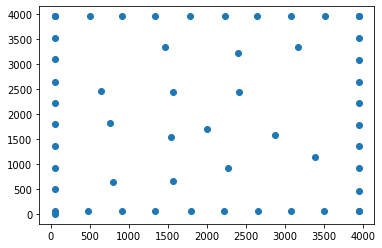

537.9252996826172
1
0 	 3 	 537.9252996826172
1 	 22 	 537.9252996826172
2 	 41 	 537.9252996826172
3 	 37 	 537.9252996826172
4 	 1 	 537.9252996826172
5 	 34 	 537.9252996826172
6 	 23 	 537.9252996826172
7 	 11 	 537.9252996826172
8 	 31 	 537.9252996826172
9 	 16 	 537.9252996826172
10 	 39 	 537.9252996826172
11 	 38 	 537.9252996826172
12 	 24 	 537.9252996826172
13 	 47 	 537.9252996826172
14 	 27 	 537.9252996826172
15 	 12 	 537.9252996826172
16 	 40 	 537.9252996826172
17 	 18 	 537.9252996826172
18 	 33 	 537.9252996826172
19 	 35 	 537.9252996826172
20 	 19 	 537.9252996826172
21 	 2 	 537.9252996826172
22 	 28 	 537.9252996826172
23 	 5 	 537.9252996826172
24 	 9 	 537.9252996826172
25 	 36 	 537.9252996826172
26 	 25 	 537.9252996826172
27 	 17 	 537.9252996826172
28 	 32 	 537.9252996826172
29 	 8 	 537.9252996826172
30 	 0 	 537.9252996826172
31 	 6 	 537.9252996826172
32 	 13 	 537.9252996826172
33 	 48 	 537.9252996826172
34 	 43 	 537.9252996826172
35 	 4 	 537.92529

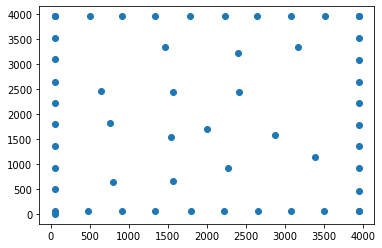

537.9252996826172
2
0 	 45 	 537.9252996826172


In [ ]:
'''try moving each of the turbines'''
for _ in range(3):
    order = np.arange(50)
    np.random.shuffle(order)
    print(_)
    for ind,index in enumerate(order):
        maxAEP,x,y = move(locs1,index,3000,100)
        #maxAEP,x,y = move_sqr(locs1,index,4000,50)
        print(ind,'\t',index,'\t',maxAEP)
        locs1[index] = x,y
    plot_turbine_locations(locs1);print(AEP_simp(np.array(locs1)));#to_csv(locs1,'iter_turb1.csv')

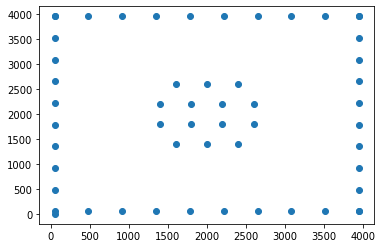

523.0351309204102


In [48]:
plot_turbine_locations(locs1);print(AEP_simp(np.array(locs1)));#to_csv(locs1,'iter_turb1.csv')

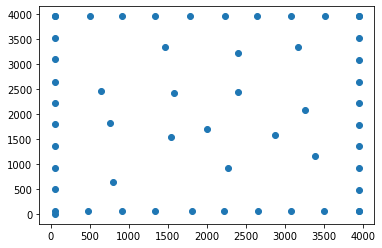

537.8450326538086


In [53]:
plot_turbine_locations(locs1);print(AEP_simp(np.array(locs1)));#to_csv(locs1,'iter_turb1.csv')

In [55]:
to_csv(locs1,'/content/iter_turb_oct10_5.csv')
# to_csv(locs1,'/content/iter_turb_xo_2.csv')
# to_csv(locs1,'/content/iter_turb_xo_3.csv')
# to_csv(locs1,'/content/iter_turb2.csv')
# to_csv(locs1,'/content/iter_turb3.csv')

In [ ]:
'''reducting the 4k x 4k grid into a 9x9 grid'''
s1   = 3950/9
locs_81 = np.array([[s1*(0.5+i),s1*(0.5+j)] for i in range(9) for j in range(9)])

In [ ]:
def generate_gene(x=50,y=81):
    order = np.arange(y)
    np.random.shuffle(order)
    gene  = np.zeros(81,dtype=np.int8)
    gene[order[:50]] = 1
    return gene

def gene_to_locs(gene,locs=locs_81):
    return locs_81.copy()[gene==1]

In [ ]:
generate_gene()


array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1], dtype=int8)

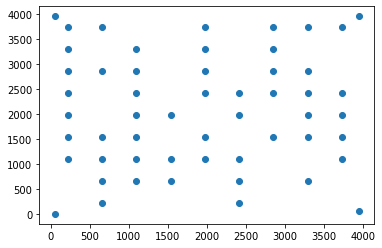

512.9857791137696


In [ ]:
locs_2 = gene_to_locs(generate_gene())
plot_turbine_locations(locs_2);print(AEP_simp(np.array(locs_2)));#to_csv(locs1,'iter_turb1.csv')

In [ ]:
dist = []
for i in range(1000):
    locs_2 = gene_to_locs(generate_gene())
    AEP = AEP_simp(locs_2)
    dist.append(AEP)

In [ ]:
dist = np.array(dist)
print(dist.min(),dist.mean(),dist.var(),dist.max())

(array([ 12.,  35.,  73., 137., 184., 224., 177.,  91.,  59.,   8.]),
 array([508. , 509.1, 510.2, 511.3, 512.4, 513.5, 514.6, 515.7, 516.8,
        517.9, 519. ]),
 <a list of 10 Patch objects>)

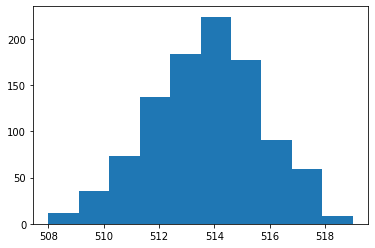

In [ ]:
dist_int = [int(i) for i in dist]
plt.hist(dist_int)

In [ ]:
def mix_genes_uni(gene1,gene2):
    l = [[] for i in range(4)]
    for ind,(g1,g2) in enumerate(zip(gene1,gene2)):
        l[g1 + 2*g2].append(ind)
    
    l1, l2  = l[1]   , l[2]
    ll1,ll2 = len(l1), len(l2)
    li1,li2 = ll1 - (ll1>>1), ll2 - (ll2>>1)
    np.random.shuffle(l1)
    np.random.shuffle(l2)
    g1,g2 = gene1.copy(), gene2.copy()
    g1[l1[:li1]] = 0
    g2[l2[:li2]] = 0
    g2[l1[:li1]] = 1
    g1[l2[:li2]] = 1
    return g1,g2

In [ ]:
x,y = 50,7
gen0 = [generate_gene() for i in range(x)]#generation 0
gen_now = gen0
for gen_cnt in range(12):
    # aeps = [[AEP_simp(i),i] for i in map(gene_to_locs,gen_now)]
    for i in range(5*x):
        a,b = -1,-1
        while a==b:
            a,b = np.random.randint(0,x), np.random.randint(0,x)
        gen_now.extend(mix_genes_uni(gen_now[a],gen_now[b]))
    aeps = [[AEP_simp(gene_to_locs(i)),i] for i in gen_now] 
    aeps.sort(reverse=True,key=lambda x:x[0])
    dist = np.array([i[0] for i in aeps])
    print(dist.min(),dist.mean(),dist.var(),dist.max())
    if dist.var()<1e-3:
        break
    gen_now = [i[1] for i in aeps[:(x-y)]] + [generate_gene() for i in range(y)]

507.75946655273435 513.9310012390137 3.092313538840415 518.7932089233399
510.9374661254883 516.8118279801803 1.9775595018841945 520.3198530578613
511.36256057739257 518.2797357396906 2.767610841737066 521.7722451782226
511.25796615600586 519.548804430875 3.239924372656211 522.7129934692383
511.4377816772461 520.6926899131082 4.086198443849699 523.1286643981933
510.48005767822264 521.4420391620982 4.601019766735093 523.4765995788574
508.6507246398926 521.6932397227893 6.666932993642956 523.7647187805176
509.4492512512207 521.9533506466952 6.231470541649951 524.0316851806641
512.8909423828125 522.5603605890449 4.618327310221209 524.1881423950196
511.4245486450195 522.4922737826261 6.690613236496065 524.3236473083496
509.58726242065427 522.4259671775125 8.812684468775851 524.5539889526367
511.122628326416 522.8809785503041 5.928650125373763 524.6499952697754


In [ ]:
locsx = [gene_to_locs(i) for i in gen_now]

In [ ]:
for ind in range(len(locsx[:5])):
    plot_turbine_locations(locsx[ind]);print(AEP_simp(np.array(locsx[ind])));

In [ ]:
def move_turbine_randomly(locs):
    while True:
        index = np.random.randint(0,50)
        angle = np.random.randint(0,360)/360*np.pi
        r     = np.random.randint(0,4000)
        dx,dy = r*np.cos(angle), r*np.sin(angle)
        
        point = [locs[index][0] + dx, locs[index][1] + dy]
        # print(dx,dy)
        if check_inc_violation(locs[:index],point) or \
            check_inc_violation(locs[index+1:],point):
            continue
        locs_copy = locs.copy()
        locs_copy[index][0] += dx
        locs_copy[index][1] += dy
        break
    return locs_copy

In [ ]:
locs_r = move_turbine_randomly(locs0)
print(np.hstack([locs0,locs_r]))

In [ ]:
# locs1 = locsx[0].copy()

In [ ]:
gen_now = [[AEP_simp(locs1),locs1.copy()]]
for gen_cnt in range(10):
    print(gen_cnt)
    nxt_gen = []
    for aep1,locs in gen_now:
        for child in range(3):
            locs1_moved = move_turbine_randomly(locs1)
            nxt_gen.append([AEP_simp(locs1_moved),locs1_moved])
    gen_now.extend(nxt_gen)
    gen_now.sort(key=lambda x:x[0], reverse=True)
    dist = np.array([i[0] for i in gen_now])
    print(dist.min(),dist.mean(),dist.var(),dist.max(),len(dist))
    gen_now = gen_now[:100]  

0
524.1442327880859 524.3235219955444 0.04268344162047872 524.6499952697754 4
1
523.5993392944335 524.2244308948517 0.09590087607677418 524.7105798339844 16
2
523.4994232177735 524.1832097697259 0.10628143849764635 524.8366946411132 64
3
523.2110032653809 524.2133168238402 0.09687846746894929 524.8366946411132 256
4
522.9932263183593 524.2897356582641 0.08602632164309551 524.8366946411132 400
5
523.1159660339356 524.2970487464904 0.11751032009899771 524.9879388427735 400
6
523.1318724060059 524.3425322822571 0.09639551464891806 524.9879388427735 400
7
523.1078791809082 524.3204202529907 0.11939007356616826 524.9879388427735 400
8
523.2590565490723 524.3097299011231 0.12654009278475528 524.9879388427735 400
9
523.259624633789 524.32629324646 0.12484306365381112 524.9879388427735 400


In [ ]:
'''try moving each of the turbines'''
for _ in range(3):
    order = np.arange(50)
    np.random.shuffle(order)
    print(_)
    for ind,index in enumerate(order):
        maxAEP,x,y = move(locs1,index,4000,50)
        #maxAEP,x,y = move_sqr(locs1,index,4000,50)
        print(ind,'\t',index,'\t',maxAEP)
        locs1[index] = x,y
    plot_turbine_locations(locs1);print(AEP_simp(np.array(locs1)));to_csv(locs1,'iter_turb_sep19_v1.csv')

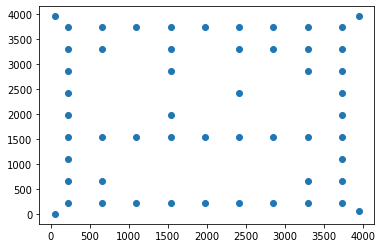

524.458650970459


In [ ]:
 plot_turbine_locations(locs1);print(AEP_simp(np.array(locs1)));#to_csv(locs1,'iter_turb1.csv')